In [1]:
%load_ext autoreload
%autoreload 2

c:\users\az55845\appdata\local\programs\python\python37\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


In [2]:
from pathlib import Path
import sys
parent_path = str(Path().joinpath('..\..').resolve())
sys.path.append(parent_path)

In [3]:
from triple_agent.parsing.replay.get_parsed_replays import get_parsed_replays
from triple_agent.constants.events import select_sc19
from triple_agent.reports.specific.character_selection import (spy_selection,
                                                      st_selection,
                                                      amba_selection,
                                                      double_agent_selection,
                                                      determine_character_in_role)
from triple_agent.reports.specific.game_outcomes import game_outcomes
from triple_agent.classes.roles import Roles
from triple_agent.classes.outcomes import WinType
from triple_agent.classes.missions import Missions, MissionStatus
from triple_agent.reports.generation.common_sort_functions import sort_by_spy_wins, sort_by_sniper_wins
from triple_agent.reports.generation.plot_specs import AxisProperties, DataQueryProperties, PlotLabelStyle
from triple_agent.reports.specific.action_tests import action_test_percentages, diff_action_test_percentages
from triple_agent.reports.specific.mission_choices import mission_choices
from triple_agent.reports.specific.mission_completes import (mission_completion_query,
    mission_completion,
    _mission_completes_details)
from triple_agent.classes.action_tests import ActionTest
from collections import Counter, defaultdict

In [4]:
replays = get_parsed_replays(lambda g: g.event == 'Winter Cup 2020')

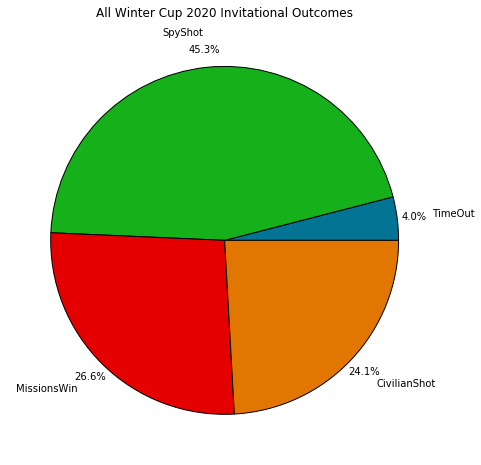

,WinType.TimeOut,WinType.SpyShot,WinType.MissionsWin,WinType.CivilianShot
NaN,26,293,172,156


In [5]:
game_outcomes(
    replays,
    axis_properties=AxisProperties(title="All Winter Cup 2020 Invitational Outcomes")
).frame

### Included Games

In [6]:
Counter((r.division, tuple(sorted([r.spy, r.sniper]))) for r in replays)

Counter({('Donner', ('Ryooo', 'tflameee')): 12,
         ('Coment', ('OpiWrites', 'TheForgot3n1')): 12,
         ('Vixen', ('Corvusmellori', 'pipesuper24')): 12,
         ('Prancer', ('iggythegrifter', 'lauras43')): 12,
         ('Cupid', ('cameraman', 'dowsey')): 12,
         ('Dancer', ('Collateral Damage', 'hunu')): 12,
         ('Dasher', ('catnip', 'pofke')): 12,
         ('Coment', ('TheForgot3n1', 'skrewwl00se')): 12,
         ('Blitzen', ('AndiVx', 'turnout8')): 12,
         ('Coment', ('OpiWrites', 'monopolyman')): 12,
         ('Vixen', ('beanie', 'humankirby')): 12,
         ('Coment', ('Tonyl', 'skrewwl00se')): 12,
         ('Vixen', ('beanie', 'pipesuper24')): 12,
         ('Dancer', ('Collateral Damage', 'lazybear')): 12,
         ('Prancer', ('lauras43', 'spedmonkey')): 12,
         ('Blitzen', ('AndiVx', 'Auglbe240')): 12,
         ('Dancer', ('basiQ', 'hunu')): 12,
         ('Coment', ('monopolyman', 'skrewwl00se')): 12,
         ('Vixen', ('humankirby', 'turnipboy')):

## Most Picked / Banned

In [7]:
BigBois = "The Big Bois"
EyeInSky = "Eye in the Sky"
CouldYouSee = "Could you see that?"

In [8]:
map_groups = {
    BigBois: {'Terrace','Gallery','Veranda','Library'},
    EyeInSky: {'Balcony','Pub','Courtyard','Moderne'},
    CouldYouSee: {'High-Rise','Ballroom','Aquarium','Teien'},
}

In [9]:
from itertools import zip_longest

def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

In [10]:
def identify_groups(played_venues):
    picked_groups = set()
    bans = set()
    for venue in played_venues:
        for group in [BigBois, EyeInSky, CouldYouSee]:
            if venue in map_groups[group]:
                picked_groups.add(group)
        if len(picked_groups) == 2:
            break
            
    for group in picked_groups:
        for venue in map_groups[group]:
            bans.add(venue)
            
    for venue in played_venues:
        bans.discard(venue)
        
    return picked_groups, bans

In [11]:
sorted_replays = sorted(replays, key=lambda g: (g.division, sorted([g.spy, g.sniper]), g.start_time))

In [12]:
only_full_set_replays = [g for g in sorted_replays if sorted([g.spy, g.sniper]) != ['dels', 'gabrio']]

In [13]:
len(sorted_replays), len(only_full_set_replays)

(647, 636)

In [14]:
all_group_picks = Counter()
all_bans = Counter()

for g in grouper(only_full_set_replays, 12):
    groups, bans = identify_groups([r.venue for r in g])
    all_group_picks.update(Counter(groups))
    all_bans.update(Counter(bans))
    
all_group_picks.most_common(), all_bans.most_common()

([('The Big Bois', 44), ('Could you see that?', 32), ('Eye in the Sky', 30)],
 [('Veranda', 14),
  ('Courtyard', 13),
  ('Teien', 12),
  ('Balcony', 12),
  ('Aquarium', 10),
  ('Terrace', 10),
  ('Gallery', 9),
  ('Library', 8),
  ('High-Rise', 8),
  ('Moderne', 6),
  ('Ballroom', 2),
  ('Pub', 2)])

In [15]:
def score_wc_set(set_replays):
    players = (set_replays[0].spy, set_replays[0].sniper)
    player_a_wins = [0]
    player_b_wins = [0]
    for replay in set_replays:
        if replay.win_type & WinType.SniperWin:
            if players[0] == replay.sniper:
                player_a_wins.append(player_a_wins[-1] + 1)
                player_b_wins.append(player_b_wins[-1])
            else:
                player_b_wins.append(player_b_wins[-1] + 1)
                player_a_wins.append(player_a_wins[-1])
        if replay.win_type & WinType.SpyWin:
            if players[0] == replay.spy:
                player_a_wins.append(player_a_wins[-1] + 1)
                player_b_wins.append(player_b_wins[-1])
            else:
                player_b_wins.append(player_b_wins[-1] + 1)
                player_a_wins.append(player_a_wins[-1])
    
    if player_a_wins[-1] < player_b_wins[-1]:
        return tuple(reversed(players)), player_b_wins, player_a_wins
    
    return players, player_a_wins, player_b_wins

In [16]:
all_score_trends = [score_wc_set(g) for g in grouper(only_full_set_replays, 12)]

In [17]:
from matplotlib import pyplot as plt

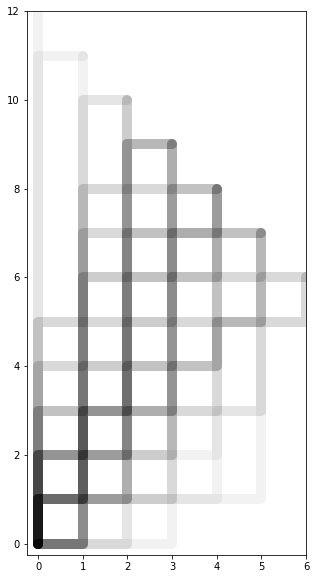

In [18]:
fig,ax = plt.subplots(figsize=(5,10))
for players, winner_wins, loser_wins in all_score_trends:
    ax.plot(loser_wins,winner_wins, marker="", linewidth=10, color='k', alpha=0.05, solid_capstyle='round')

ax.set_ylim(-.25,12)
ax.set_xlim(-.25,6)
plt.show()

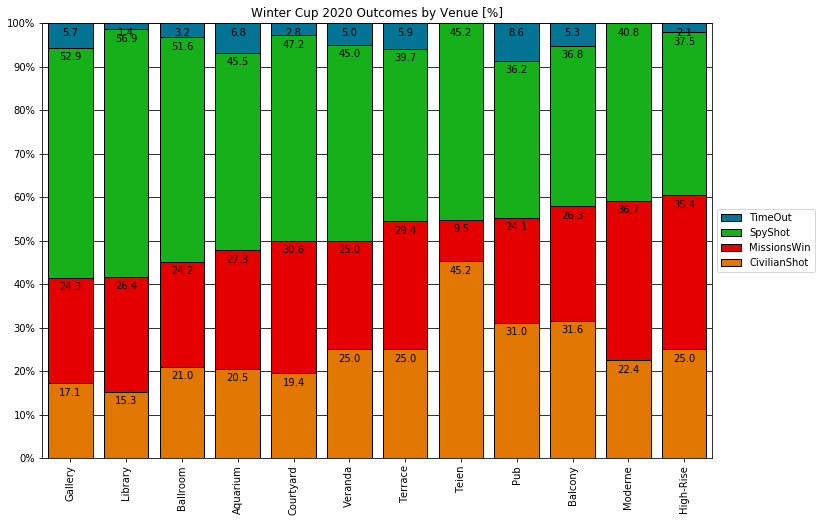

,Gallery,Library,Ballroom,Aquarium,Courtyard,Veranda,Terrace,Teien,Pub,Balcony,Moderne,High-Rise
WinType.TimeOut,0.057143,0.013889,0.032258,0.068182,0.027778,0.05,0.058824,0.000000,0.086207,0.052632,0.000000,0.020833
WinType.SpyShot,0.528571,0.569444,0.516129,0.454545,0.472222,0.45,0.397059,0.452381,0.362069,0.368421,0.408163,0.375000
WinType.MissionsWin,0.242857,0.263889,0.241935,0.272727,0.305556,0.25,0.294118,0.095238,0.241379,0.263158,0.367347,0.354167
WinType.CivilianShot,0.171429,0.152778,0.209677,0.204545,0.194444,0.25,0.250000,0.452381,0.310345,0.315789,0.224490,0.250000


In [19]:
game_outcomes(
    replays,
    DataQueryProperties(
        groupby=lambda g: g.venue,
        secondary_order=sort_by_spy_wins,
        percent_normalized_data=True,
    ),
    axis_properties=AxisProperties(
        title="Winter Cup 2020 Outcomes by Venue [%]",
        data_label_style=PlotLabelStyle.Plain,
    )
).frame

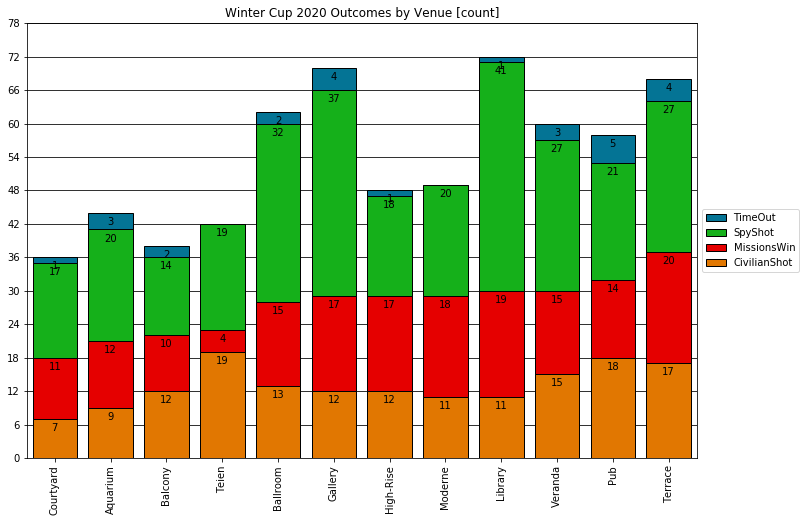

,Courtyard,Aquarium,Balcony,Teien,Ballroom,Gallery,High-Rise,Moderne,Library,Veranda,Pub,Terrace
WinType.TimeOut,1,3,2,0,2,4,1,0,1,3,5,4
WinType.SpyShot,17,20,14,19,32,37,18,20,41,27,21,27
WinType.MissionsWin,11,12,10,4,15,17,17,18,19,15,14,20
WinType.CivilianShot,7,9,12,19,13,12,12,11,11,15,18,17


In [20]:
game_outcomes(
    replays,
    DataQueryProperties(
        groupby=lambda g: g.venue,
        secondary_order=sort_by_spy_wins,
    ),
    axis_properties=AxisProperties(
        title="Winter Cup 2020 Outcomes by Venue [count]",
        data_label_style=PlotLabelStyle.Plain,
    )
).frame

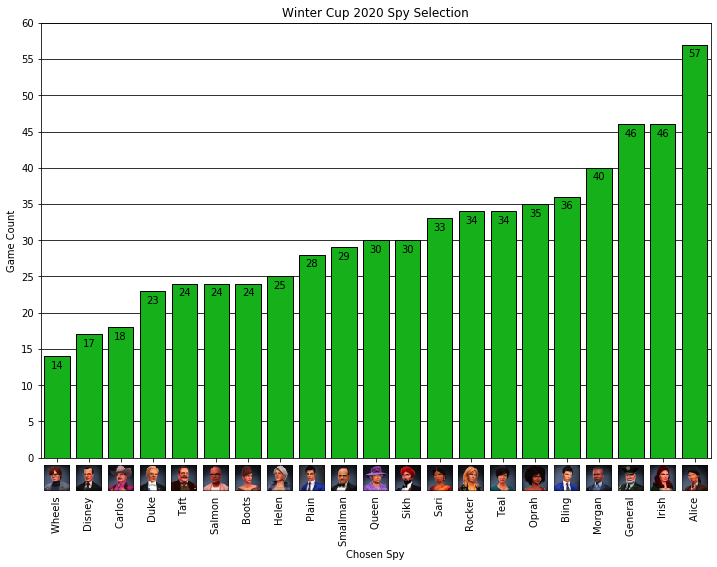

In [21]:
_ = spy_selection(
    replays,
    axis_properties = AxisProperties(
        title="Winter Cup 2020 Spy Selection",
        x_axis_portrait=True,
        y_axis_label="Game Count",
        x_axis_label="Chosen Spy",
    ),
    data_query = DataQueryProperties(
        primary_order=sum,
    )
)

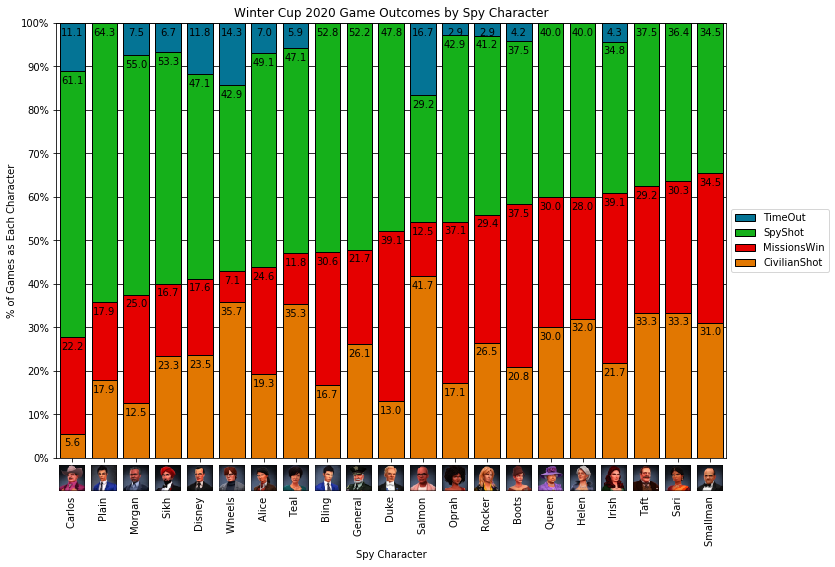

In [22]:
_ = game_outcomes(
    replays,
    axis_properties = AxisProperties(
        title="Winter Cup 2020 Game Outcomes by Spy Character",
        x_axis_portrait=True,
        y_axis_label="% of Games as Each Character",
        x_axis_label="Spy Character",
        data_label_style=PlotLabelStyle.Plain,
    ),
    data_query = DataQueryProperties(
        groupby=lambda g: determine_character_in_role(g, Roles.Spy),
        secondary_order=sort_by_spy_wins,
        percent_normalized_data=True
    )
)

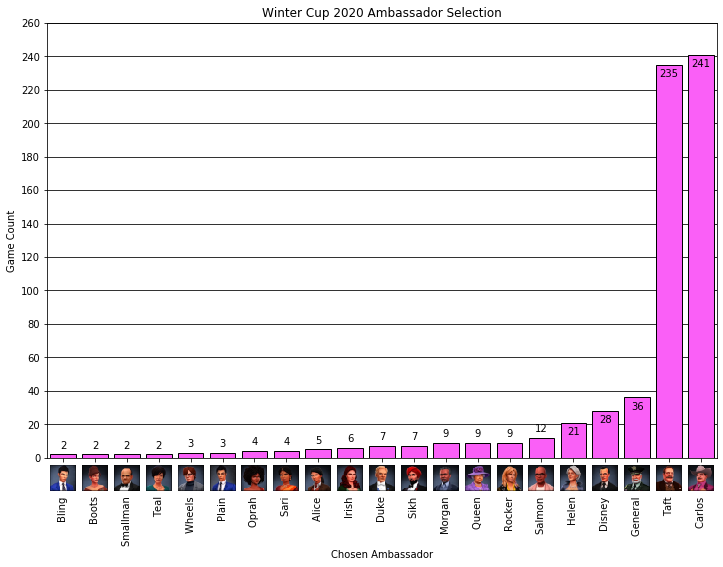

In [23]:
_ = amba_selection(
    replays,
    axis_properties = AxisProperties(
        title="Winter Cup 2020 Ambassador Selection",
        x_axis_portrait=True,
        y_axis_label="Game Count",
        x_axis_label="Chosen Ambassador",
    ),
    data_query = DataQueryProperties(
        primary_order=sum,
    )
)

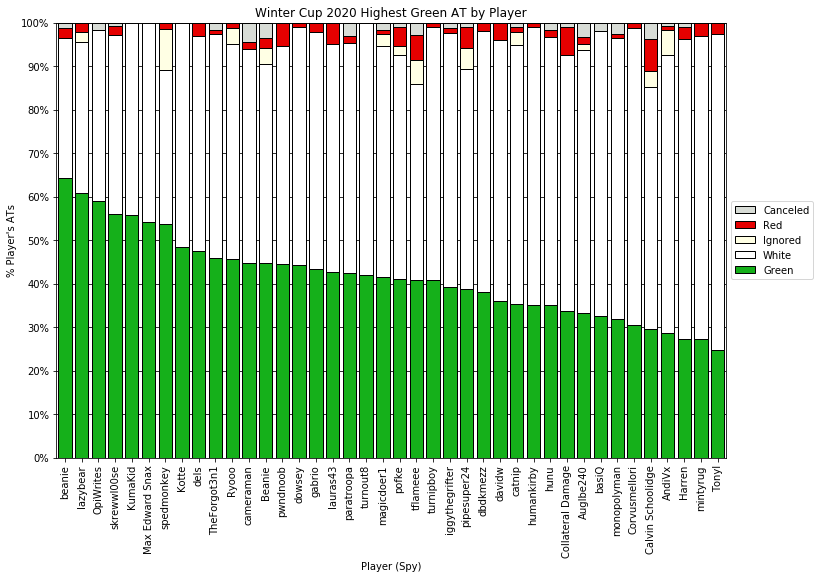

In [24]:
_ = action_test_percentages(
    replays,
    axis_properties = AxisProperties(
        title='Winter Cup 2020 Highest Green AT by Player',
        x_axis_label='Player (Spy)',
        y_axis_label='% Player\'s ATs',
    ),
    data_query = DataQueryProperties(
        groupby=lambda g: g.spy,
        secondary_order=lambda name_series: -name_series[1][ActionTest.Green],
        reverse_primary_order=True,
        percent_normalized_data=True)    
)

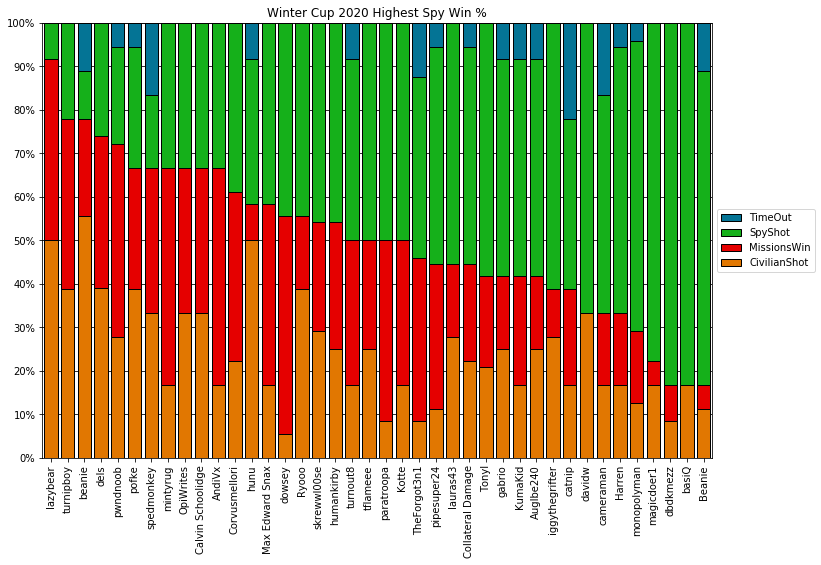

In [25]:
spy_winr = game_outcomes(
    replays,
    DataQueryProperties(
        groupby=lambda g: g.spy,
        secondary_order=sort_by_spy_wins,
        reverse_secondary_order=True,
        percent_normalized_data=True),
    axis_properties=AxisProperties(title="Winter Cup 2020 Highest Spy Win %")
)

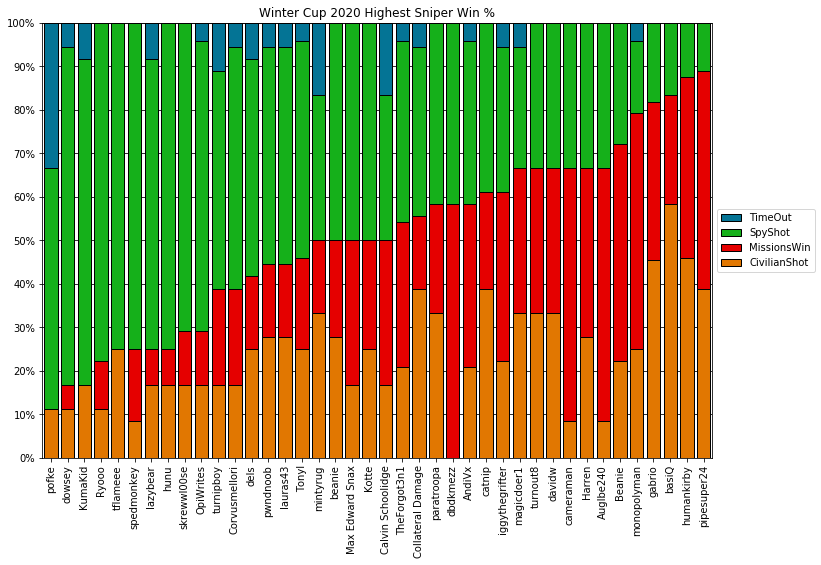

In [26]:
_ = game_outcomes(
    replays,
    DataQueryProperties(
        groupby=lambda g: g.sniper,
        secondary_order=sort_by_sniper_wins,
        reverse_secondary_order=True,
        percent_normalized_data=True),
    axis_properties=AxisProperties(title="Winter Cup 2020 Highest Sniper Win %")
)

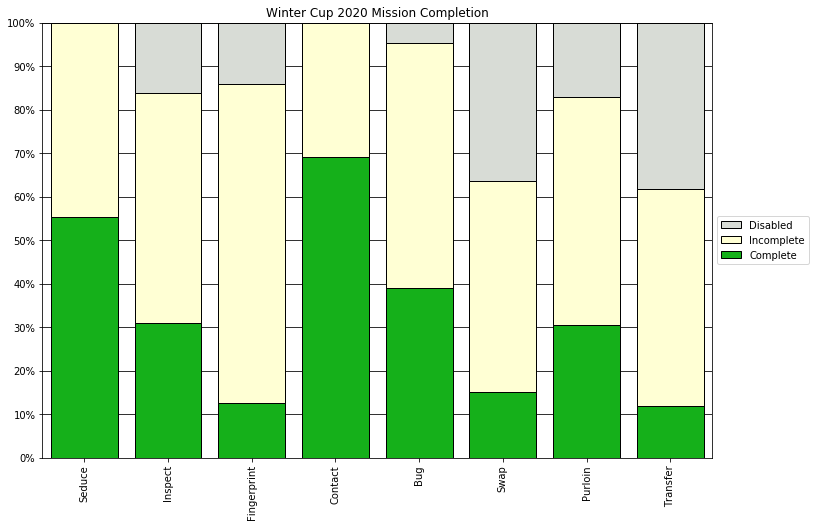

In [27]:
mission_completion(replays, "Winter Cup 2020 Mission Completion")